<h1> Problem Statement </h1>

Managing the Dutch railway network in order to get trains to their destination safely and on time requires accurate knowledge of the location and state of the various assets on the rail. But how to cope with the bookkeeping when you have over 7000 km of railway? While at the same time maintenance is outsourced to multiple contractors who also have their own systems? ProRail has developed a computer vision solution to verify, update and correct the existing database, rather than sending people out in the field and relying on manual labour. Special trains, equipped with cameras, regularly capture the entire Dutch railway on film. Using convolutional neural networks, assets are identified and localized. Not only is it more efficient than manual inspection, it also has a higher accuracy.

# Instructions to set Kaggle API :

Prerequisits are : 

- Have Kaggle Account 

- Prescribed Platform : Google Colab

1. Log In your Kaggle Account 

2. Go to your account, Scroll to API section.

3. Click on Create New API Token - It will download kaggle.json file on your machine.

4. Go to your Google Colab project file and run the following commands:

  -  !pip install -q kaggle

  -  from google.colab import files

  -  files.upload() #Choose the kaggle.json file that you downloaded

  -  !mkdir ~/.kaggle

  -  !cp kaggle.json ~/.kaggle/ #Copies kaggle.json in kggle directory

  -  !chmod 600 ~/.kaggle/kaggle.json

**For Further Information Visit : https://www.kaggle.com/general/74235**

# Setup Kaggle Data

In [1]:
!pip install -q kaggle

In [2]:
from google.colab import files
import os

In [3]:
!ls

drive  sample_data


In [4]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"himanshubirla9194","key":"0dd2d4ec72da51baff9d620bc379df40"}'}

In [5]:
 !mkdir ~/.kaggle

In [6]:
!cp kaggle.json ~/.kaggle/

In [7]:
 !chmod 600 ~/.kaggle/kaggle.json

In [8]:
!kaggle datasets list

ref                                                       title                                               size  lastUpdated          downloadCount  
--------------------------------------------------------  -------------------------------------------------  -----  -------------------  -------------  
thomaskonstantin/highly-rated-children-books-and-stories  Highly Rated Children Books And Stories            106KB  2020-10-24 12:09:59             71  
rishidamarla/judicial-expenditures-across-all-50-states   Judicial Expenditures across all 50 States           2KB  2020-10-25 00:07:45             40  
kanishk307/6000-indian-food-recipes-dataset               6000+ Indian Food Recipes Dataset                    9MB  2020-10-24 01:08:23            100  
balraj98/synthetic-objective-testing-set-sots-reside      Synthetic Objective Testing Set (SOTS) [RESIDE]    415MB  2020-10-24 10:07:29              6  
salmaneunus/mechanical-tools-dataset                      Mechanical Tools Classif

In [9]:
!kaggle datasets download -d oscarvanhees/insulation-joint-training-set-prorail

100% 1.76G/1.76G [00:13<00:00, 36.4MB/s]
100% 1.76G/1.76G [00:14<00:00, 135MB/s] 


In [10]:
!ls

drive  insulation-joint-training-set-prorail.zip  kaggle.json  sample_data


In [10]:
!mkdir prorail

In [11]:
! unzip insulation-joint-training-set-prorail.zip -d prorail

Streaming output truncated to the last 5000 lines.
  inflating: prorail/trainset_insulation_joint/images/2420_3_22_34940.jpg  
  inflating: prorail/trainset_insulation_joint/images/2420_3_22_34941.jpg  
  inflating: prorail/trainset_insulation_joint/images/2420_3_22_34942.jpg  
  inflating: prorail/trainset_insulation_joint/images/2420_3_22_34943.jpg  
  inflating: prorail/trainset_insulation_joint/images/2420_3_22_34944.jpg  
  inflating: prorail/trainset_insulation_joint/images/2420_3_22_34945.jpg  
  inflating: prorail/trainset_insulation_joint/images/2420_3_22_34946.jpg  
  inflating: prorail/trainset_insulation_joint/images/2420_3_22_34947.jpg  
  inflating: prorail/trainset_insulation_joint/images/2420_3_22_34980.jpg  
  inflating: prorail/trainset_insulation_joint/images/2420_3_22_34981.jpg  
  inflating: prorail/trainset_insulation_joint/images/2420_3_22_34982.jpg  
  inflating: prorail/trainset_insulation_joint/images/2420_3_22_34983.jpg  
  inflating: prorail/trainset_insulat

In [12]:
!ls

drive					   kaggle.json	sample_data
insulation-joint-training-set-prorail.zip  prorail


In [13]:
os.chdir('/content/prorail/trainset_insulation_joint/')

In [15]:
!ls

images	labels.csv


# Import Libraries 

In [163]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator , load_img ,img_to_array, array_to_img
from sklearn.model_selection import train_test_split as tts
import PIL
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Flatten,Dropout,Conv2D,MaxPool2D,ZeroPadding2D,Input
from tensorflow.keras.optimizers import RMSprop, Adam ,SGD
from skimage.transform import resize
from sklearn.metrics import classification_report

# Reading and Pre-Processing Data

In [15]:
data=pd.read_csv('labels.csv',delimiter=';')

In [19]:
data.head()

ID label           filepath
0     2420_2_0_0     n     2420_2_0_0.jpg
1  2420_2_0_2124     n  2420_2_0_2124.jpg
2  2420_2_0_4225     n  2420_2_0_4225.jpg
3  2420_2_0_4227     n  2420_2_0_4227.jpg
4  2420_2_0_4250     n  2420_2_0_4250.jpg

In [16]:
img_path='/content/prorail/trainset_insulation_joint/images/'
data['img_path']=img_path + data['filepath']

In [21]:
data.head()

ID  ...                                           img_path
0     2420_2_0_0  ...  /content/prorail/trainset_insulation_joint/ima...
1  2420_2_0_2124  ...  /content/prorail/trainset_insulation_joint/ima...
2  2420_2_0_4225  ...  /content/prorail/trainset_insulation_joint/ima...
3  2420_2_0_4227  ...  /content/prorail/trainset_insulation_joint/ima...
4  2420_2_0_4250  ...  /content/prorail/trainset_insulation_joint/ima...

[5 rows x 4 columns]

In [22]:
data.ID.nunique()

28201

In [23]:
data.shape

(28201, 4)

In [24]:
data.label.value_counts()

n    26538
p     1663
Name: label, dtype: int64

In [17]:
X=data.drop('label',axis=1)
y=data['label']

In [18]:
train_X,test_X,train_y,test_y=tts(X,y,test_size=.40,random_state=41)

In [27]:
train_X.shape

(16920, 3)

In [28]:
test_X.shape

(11281, 3)

In [29]:
train_y.value_counts()

n    15940
p      980
Name: label, dtype: int64

In [30]:
test_y.value_counts()

n    10598
p      683
Name: label, dtype: int64

In [19]:
train_dir=train_X['img_path']
test_dir=test_X['img_path']

In [20]:
train_dir.reset_index(drop=True,inplace=True)

In [117]:
train_img=np.zeros((len(train_dir),64,64,1))
for i in range(0,len(train_dir)):
  img=PIL.Image.open(train_dir[i]).convert('L')
  #img=img.resize((28,28,3))
  img=img_to_array(img)
  img = resize(img, (64, 64), mode='reflect')
  
  train_img[i]=img

  #train_img.append(img)


In [22]:
test_dir.reset_index(drop=True,inplace=True)

In [135]:
test_img=np.zeros((len(test_dir),64,64,1))
for i in range(0,len(test_dir)):
  img=PIL.Image.open(test_dir[i]).convert('L')
  
  img=img_to_array(img)
  img = resize(img, (64, 64), mode='reflect')
  
  test_img[i]=img

  #train_img.append(img)


In [121]:
target={'n':0,'p':1}
train_y.replace(target,inplace=True)
test_y.replace(target,inplace=True)

# Model

In [147]:
model=Sequential()
model.add(Conv2D(32,(3,3),activation='relu',padding='same',input_shape=(64,64,1)))
model.add(MaxPool2D(2,2))
model.add(Conv2D(64,(3,3),activation='relu',padding='same'))
model.add(MaxPool2D(2,2))
model.add(Conv2D(128,(3,3),activation='relu',padding='same'))
model.add(MaxPool2D(2,2))
model.add(Conv2D(256,(3,3),activation='relu',padding='same'))
model.add(MaxPool2D(2,2))
model.add(Conv2D(512,(3,3),activation='relu'))
model.add(Flatten())
model.add(Dense(512,activation='relu'))
model.add(Dense(1,activation='sigmoid'))
opt=SGD(learning_rate=.01,momentum=.9)
model.compile(optimizer=opt,loss='binary_crossentropy',metrics=['acc'])


In [148]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_20 (Conv2D)           (None, 64, 64, 32)        320       
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 16, 16, 128)       73856     
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 8, 8, 256)        

In [149]:
history=model.fit(train_img,train_y,batch_size=32,epochs=15,validation_data=(test_img,test_y))

Epoch 1/15
529/529 [==============================] - 6s 10ms/step - loss: 0.1997 - acc: 0.9411 - val_loss: 0.1134 - val_acc: 0.9481
Epoch 2/15
529/529 [==============================] - 5s 10ms/step - loss: 0.0944 - acc: 0.9613 - val_loss: 0.0692 - val_acc: 0.9744
Epoch 3/15
529/529 [==============================] - 5s 10ms/step - loss: 0.0774 - acc: 0.9719 - val_loss: 0.0579 - val_acc: 0.9791
Epoch 4/15
529/529 [==============================] - 5s 10ms/step - loss: 0.0574 - acc: 0.9785 - val_loss: 0.0729 - val_acc: 0.9734
Epoch 5/15
529/529 [==============================] - 5s 10ms/step - loss: 0.0511 - acc: 0.9813 - val_loss: 0.0605 - val_acc: 0.9778
Epoch 6/15
529/529 [==============================] - 5s 10ms/step - loss: 0.0423 - acc: 0.9845 - val_loss: 0.0491 - val_acc: 0.9813
Epoch 7/15
529/529 [==============================] - 5s 10ms/step - loss: 0.0397 - acc: 0.9856 - val_loss: 0.0895 - val_acc: 0.9778
Epoch 8/15
529/529 [==============================] - 5s 10ms/step - 

In [150]:
epochs=history.epoch
acc=history.history['acc']
loss=history.history['loss']
val_acc=history.history['val_acc']
val_loss=history.history['val_loss']

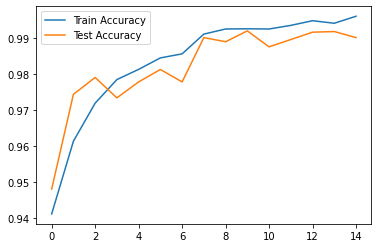

In [151]:
plt.plot(epochs,acc,label='Train Accuracy')
plt.plot(epochs,val_acc,label='Test Accuracy')
plt.legend()

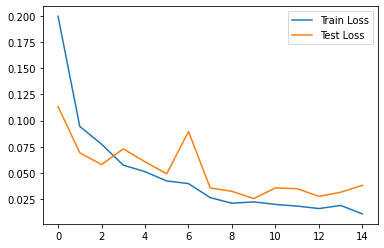

In [152]:
plt.plot(epochs,loss,label='Train Loss')
plt.plot(epochs,val_loss,label='Test Loss')
plt.legend()

We see that the model has to generalized well 

In [166]:
y_pred_train=model.predict_classes(train_img)

In [158]:
y_pred=model.predict_classes(test_img)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


In [161]:
np.unique(y_pred)

array([0, 1], dtype=int32)

In [162]:
test_y

19689    0
8788     0
1174     0
6020     0
7332     0
        ..
17903    0
1957     0
6150     0
11994    0
6356     0
Name: label, Length: 11281, dtype: int64

In [165]:
print(classification_report(test_y,y_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99     10598
           1       0.95      0.89      0.92       683

    accuracy                           0.99     11281
   macro avg       0.97      0.94      0.96     11281
weighted avg       0.99      0.99      0.99     11281



In [167]:
print(classification_report(train_y,y_pred_train))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     15940
           1       0.99      0.97      0.98       980

    accuracy                           1.00     16920
   macro avg       0.99      0.98      0.99     16920
weighted avg       1.00      1.00      1.00     16920

